In [1]:
import pandas as pd
import numpy as np
import scipy

from pandas_datareader import data, wb

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from pandas.tseries.offsets import *

import plotly.plotly as py
import plotly.graph_objs as go


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname = 'strategy_340240'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame(d.exo)
#df['close'] = d.exo
#df['vol'] = d.volume

In [4]:
for i in range(10,100,10):

    bb_period = i
    bb_k = 2
    df['bb_central_line'+str(i)] = df.exo.rolling(bb_period).mean()
    df['bb_upperband'+str(i)] = df['bb_central_line'+str(i)] + (bb_k * df['bb_central_line'+str(i)].rolling(bb_period).std())
    df['bb_lowerband'+str(i)] = df['bb_central_line'+str(i)] - (bb_k * df['bb_central_line'+str(i)].rolling(bb_period).std())

#df['bb_multiperiod_central_line'] = df.filter(like='centr').mean(axis=1)    
#df['bb_multiperiod_upperband'] = df.filter(like='upper').mean(axis=1)
#df['bb_multiperiod_lowerband'] = df.filter(like='lower').mean(axis=1)

#df = df.drop(df.filter(like='centr').columns, axis=1).drop(df.filter(like='upper').columns, axis=1).drop(df.filter(like='lower').columns, axis=1)

In [5]:
bb_period = 20
bb_k = 2
df['bb_central_line'] = df.exo.rolling(bb_period).mean()
df['bb_upperband'] = df.bb_central_line + (bb_k * df.bb_central_line.rolling(bb_period).std())
df['bb_lowerband'] = df.bb_central_line - (bb_k * df.bb_central_line.rolling(bb_period).std())

df['bb_%b'] = (df.exo - df['bb_lowerband']) / (df['bb_upperband'] - df['bb_lowerband'])
df['bb_width'] = (df['bb_upperband'] - df['bb_lowerband'])

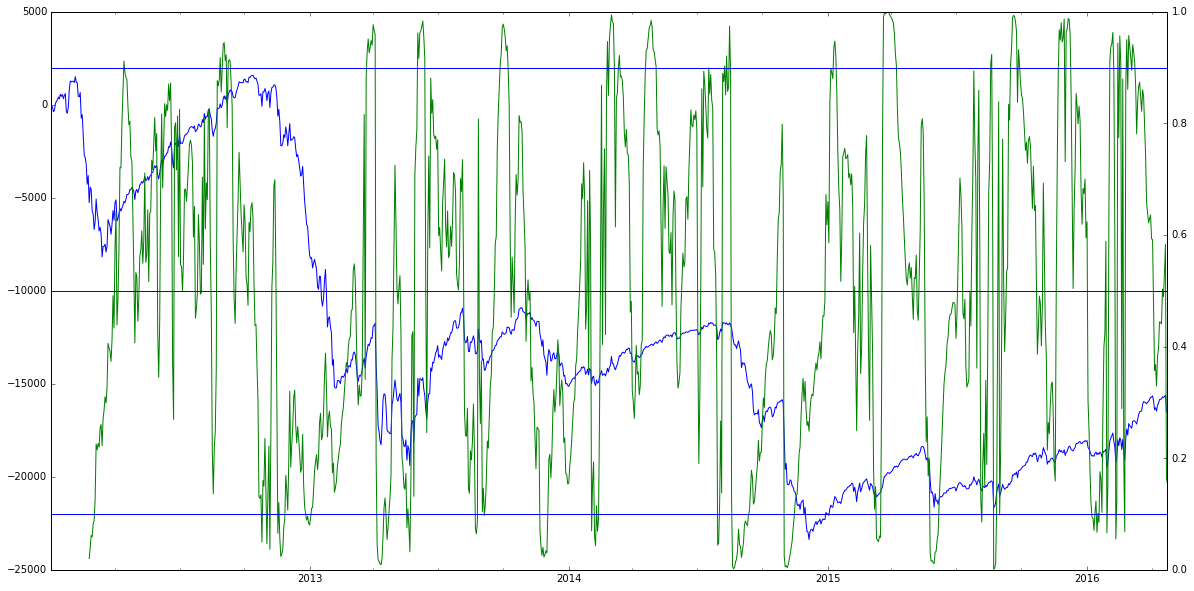

In [6]:
df.exo.plot()
df['bb_%b'].rank(pct=True).plot(secondary_y=True)
axhline(0.5)
axhline(0.9)
axhline(0.1)

In [46]:
#py.sign_in('tmqr', '8rctfyu197')
py.sign_in('dmveden', 'rzbs7xw8ft')

##  Uptrend condition became true if  difference between close price and upper band more than its median.

In [58]:
exo = go.Scatter(
    x = df.exo.index,
    y = df.exo,
    name='EXO Price',
    mode = 'line',
    marker = dict(symbol="spline", size=5, color = 'rgba(255, 0, 0, 0.9)'),
    text = df.exo.index
)

bbupper = go.Scatter(
    x = df.bb_upperband.index,
    y = df.bb_upperband,
    name = 'BBands upper band',
    mode = 'lines+markers',
    marker = dict(symbol="hash", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    text = [df.bb_upperband],
    yaxis='y1'
    ) 

uptrend_ind = go.Scatter(
    x = df.bb_upperband.index,
    y = (df.exo - df.bb_upperband),
    name = 'Indicator value',
    #mode = 'lines+markers',
    line = dict(dash="hash", width=3, color = 'rgba(122, 178, 234, 0.9)'),
    #text = df.bb_upperband.values,
    yaxis='y2'
    ) 

uptrend_med = go.Scatter(
    x = df.bb_upperband.index,
    y = (df.exo - df.bb_upperband).rolling(10).median(),
    name = 'Indicator rolling median',
    #mode = 'lines+markers',
    line = dict(dash="dot", width=2, color = 'rgba(7, 94, 90, 0.9)'),
    #text = [df.bb_upperband],
    yaxis='y2'
    ) 


plot = [exo, bbupper, uptrend_ind, uptrend_med]

layout = go.Layout(
    title="TITLE",
    xaxis=dict(type='date', range=[1404172800000, 1431648000000]),
    yaxis1=dict(
        title='EXO Price',
        zeroline=False
    ),
    #yaxis=dict(zeroline=False),
    yaxis2=dict(
        #title='Percentage Rank of b%',
        overlaying='y',
        side='right',
        zeroline=False
    ),
    annotations=[
        dict(
            x='2014-12-09',
            y=-22852,
            xref='x',
            yref='y',
            text='Long signal',
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=50,
            arrowcolor='#58E366'
        ),
        dict(
            x='2014-08-19',
            y=-12000,
            xref='x',
            yref='y',
            text='Short signal',
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-50,
            arrowcolor='#F75353'
        )
    ]

    )
fig = go.Figure(data=plot, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

In [13]:
trace1 = go.Scatter(
    x = df.exo.index,
    y = df.exo,
    name='EXO Price',
    mode = 'lines',
    marker = dict(symbol="spline", size=5, color = 'rgba(255, 0, 0, 0.9)'),
    text = df.exo.index
)

trace2 = go.Scatter(
    x = df['bb_%b'].rank(pct=True).index,
    y = df['bb_%b'].rank(pct=True)*100,
    name = 'Percentage Rank of b%',
    mode = 'lines+markers',
    marker = dict(symbol="hash", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    text = [df.exo.index, df['bb_%b'].rank(pct=True).values],
    yaxis='y2'
    ) 

hline1 = go.Scatter(
    x = df.exo.index,
    y = pd.Series(90, index=df.exo.index),
    showlegend = False,
    mode = 'lines+markers',
    marker = dict(symbol="hash", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    #text = [df.exo.index, df['bb_%b'].rank(pct=True).values],
    yaxis='y2',
    hoverinfo='none'
    )

hline2 = go.Scatter(
    x = df.exo.index,
    y = pd.Series(10, index=df.exo.index),
    showlegend = False,
    mode = 'lines+markers',
    marker = dict(symbol="hash", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    #text = [df.exo.index, df['bb_%b'].rank(pct=True).values],
    yaxis='y2',
    hoverinfo='none'
    )

hline3 = go.Scatter(
    x = df.exo.index,
    y = pd.Series(50, index=df.exo.index),
    showlegend = False,
    mode = 'lines+markers',
    marker = dict(symbol="hash", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    #text = [df.exo.index, df['bb_%b'].rank(pct=True).values],
    yaxis='y2',
    hoverinfo='none'
    )

plot = [trace1, trace2, hline1, hline2, hline3]

layout = go.Layout(
    title="Bolinger Bands",
    
    yaxis1=dict(
        title='EXO Price'
    ),
    
    yaxis2=dict(
        title='Percentage Rank of b%',
        overlaying='y',
        side='right'
    )

    )
fig = go.Figure(data=plot, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

In [50]:
exo = go.Scatter(
    x = df.exo.index,
    y = df.exo,
    name='EXO Price',
    mode = 'line',
    marker = dict(symbol="spline", size=5, color = 'rgba(255, 0, 0, 0.9)'),
    text = df.exo.index
)

bbupper = go.Scatter(
    x = df.bb_upperband.index,
    y = df.bb_upperband,
    name = 'BBands upper band',
    mode = 'lines+markers',
    marker = dict(symbol="hash", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    text = [df.bb_upperband],
    yaxis='y1'
    ) 

uptrend_ind = go.Scatter(
    x = df.bb_upperband.index,
    y = (df.exo - df.bb_upperband),
    name = 'Indicator value',
    #mode = 'lines+markers',
    line = dict(dash="hash", width=3, color = 'rgba(122, 178, 234, 0.9)'),
    #text = df.bb_upperband.values,
    yaxis='y2'
    ) 

uptrend_med = go.Scatter(
    x = df.bb_upperband.index,
    y = (df.exo - df.bb_upperband).rolling(10).median(),
    name = 'Indicator rolling median',
    #mode = 'lines+markers',
    line = dict(dash="dot", width=2, color = 'rgba(7, 94, 90, 0.9)'),
    #text = [df.bb_upperband],
    yaxis='y2'
    ) 


plot = [exo, bbupper, uptrend_ind, uptrend_med]

layout = go.Layout(
    title="TITLE",
    xaxis=dict(type='date', range=[1404172800000, 1431648000000]),
    
    yaxis1=dict(
        title='EXO Price'
    ),
    
    yaxis2=dict(
        #title='Percentage Rank of b%',
        overlaying='y',
        side='right'
    ),
    annotations=[
        dict(
            x='2014-12-09',
            y=-22852,
            xref='x',
            yref='y',
            text='Long signal',
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=50,
            arrowcolor='#58E366'
        ),
        dict(
            x='2014-08-19',
            y=-12000,
            xref='x',
            yref='y',
            text='Short signal',
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-50,
            arrowcolor='#F75353'
        )
    ]

    )
fig = go.Figure(data=plot, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

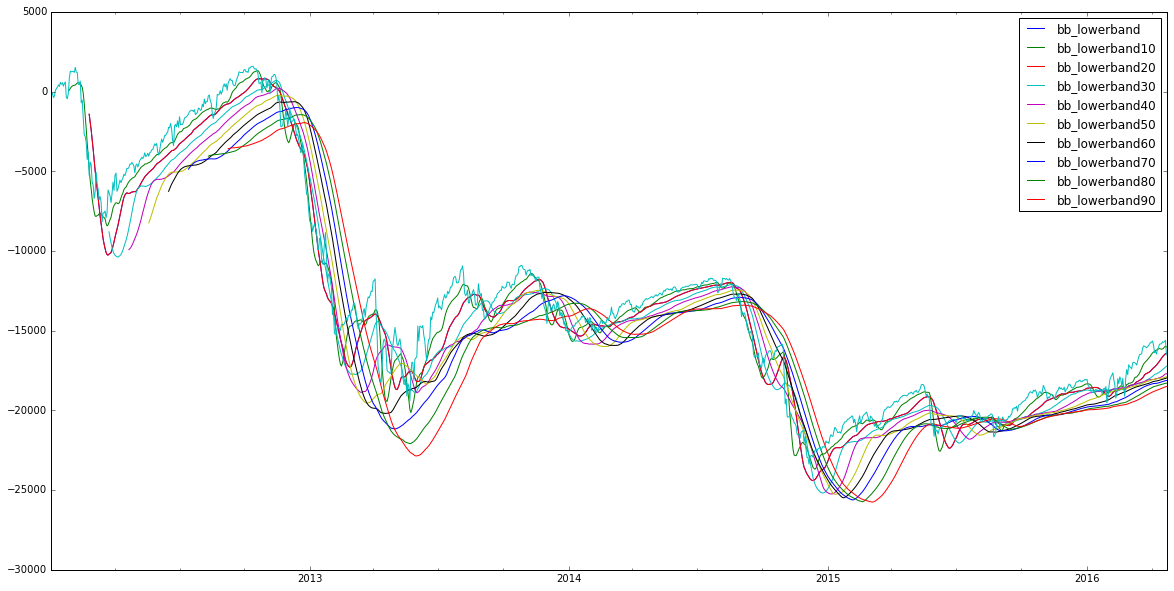

In [25]:
#df.filter(like='upper').plot()
df.filter(like='lowe').plot()
df.exo.plot()

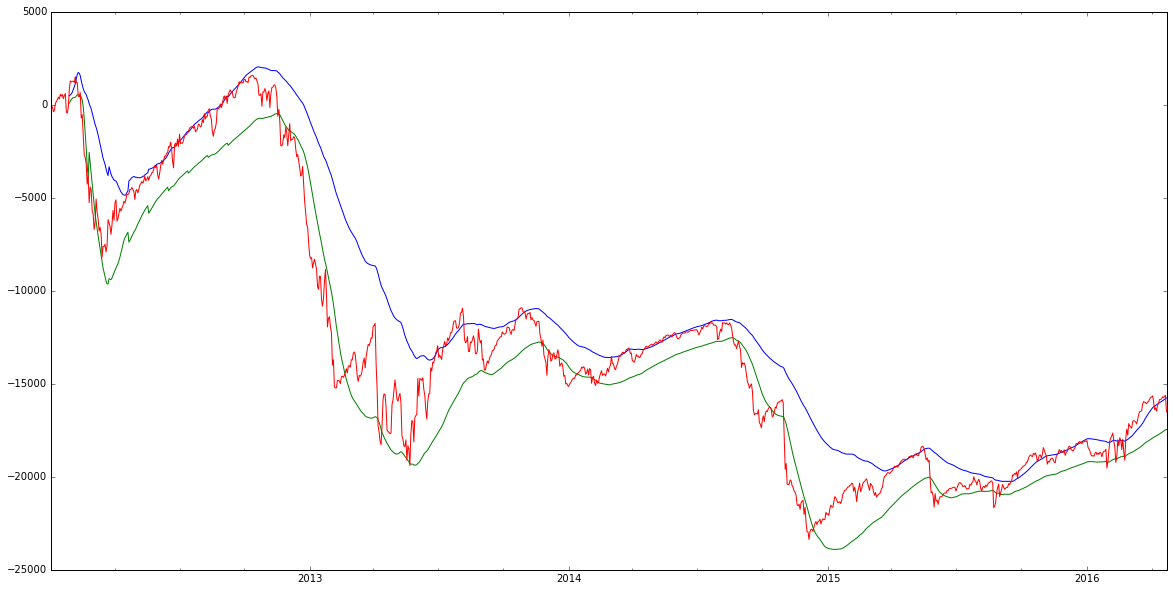

In [26]:
df.filter(like='upper').mean(axis=1).plot()
df.filter(like='lowe').mean(axis=1).plot()
df.exo.plot()

In [35]:
df.bb_multiperiod_width.plot(secondary_y=True)
df.exo.plot(label='sd')

AttributeError: 'DataFrame' object has no attribute 'bb_multiperiod_width'

### ???????

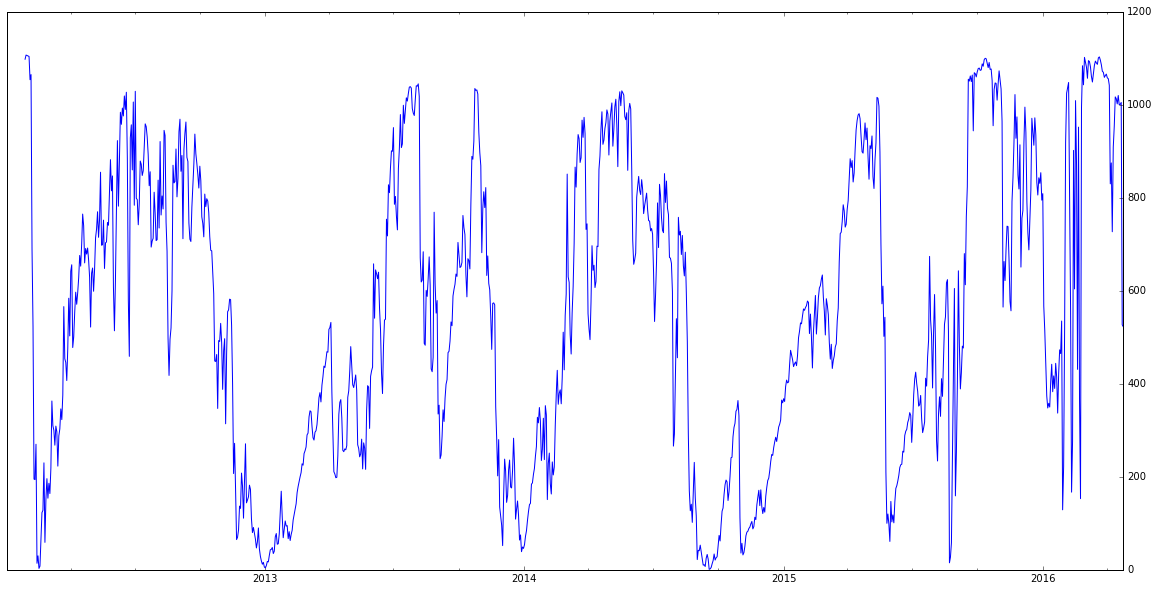

In [53]:
df['bb_multiperiod_%b'].rank().plot(secondary_y=True)

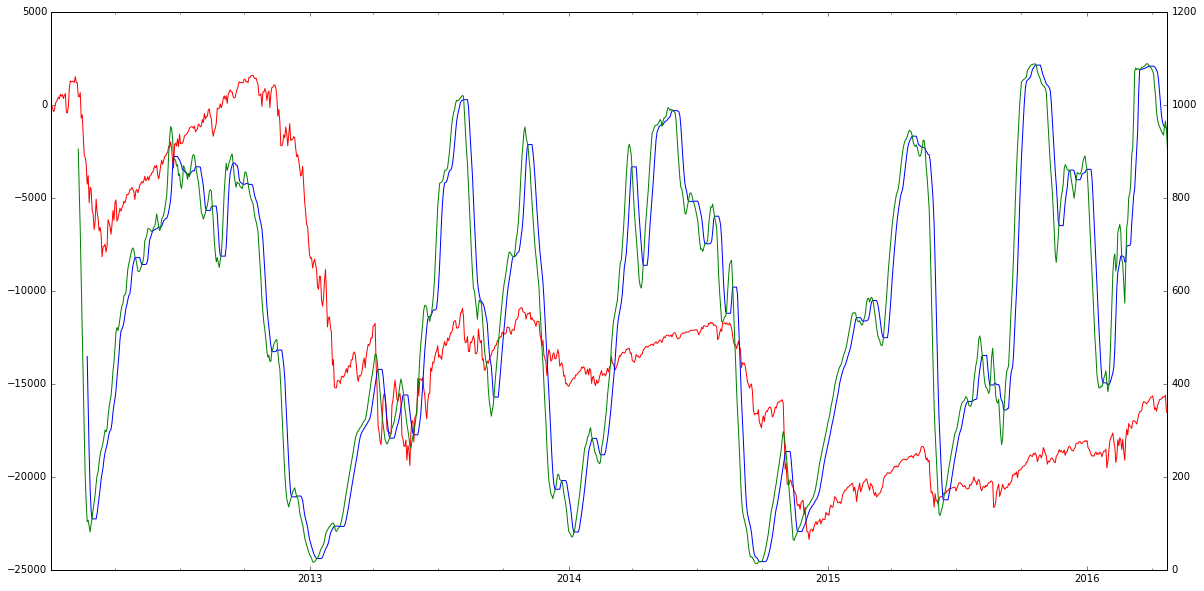

In [54]:
df['bb_multiperiod_%b'].rank().rolling(10).mean().rolling(10).median().plot(secondary_y=True)
df['bb_multiperiod_%b'].rank().rolling(10).mean().plot(secondary_y=True)
df.exo.plot()

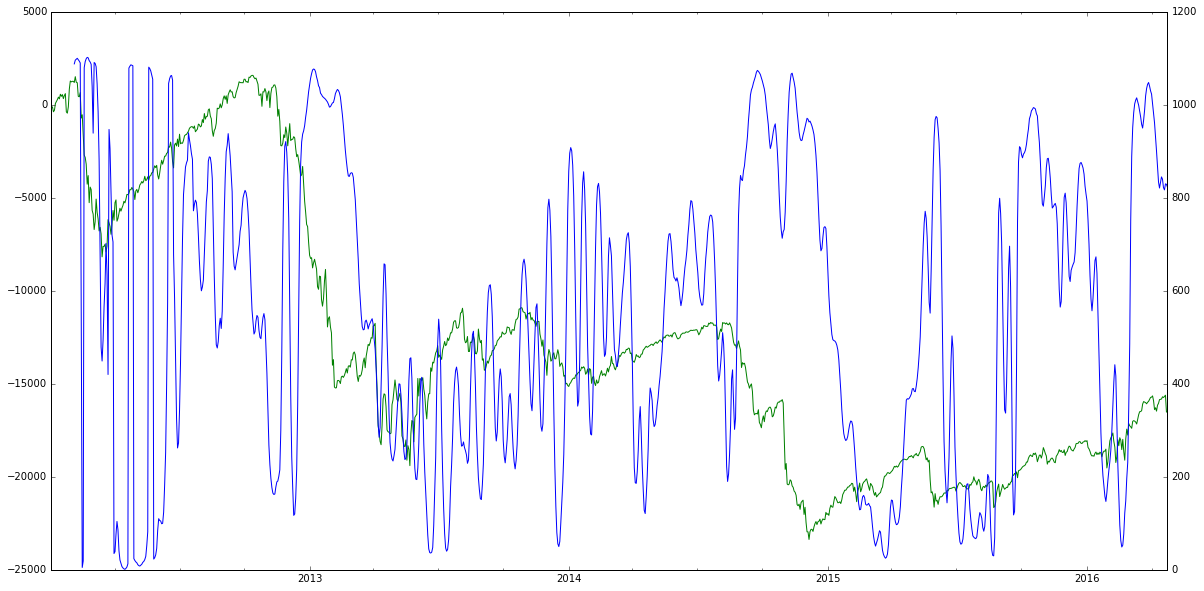

In [55]:
df.bb_multiperiod_width.pct_change(5).rank().plot(secondary_y=True)
df.exo.plot()

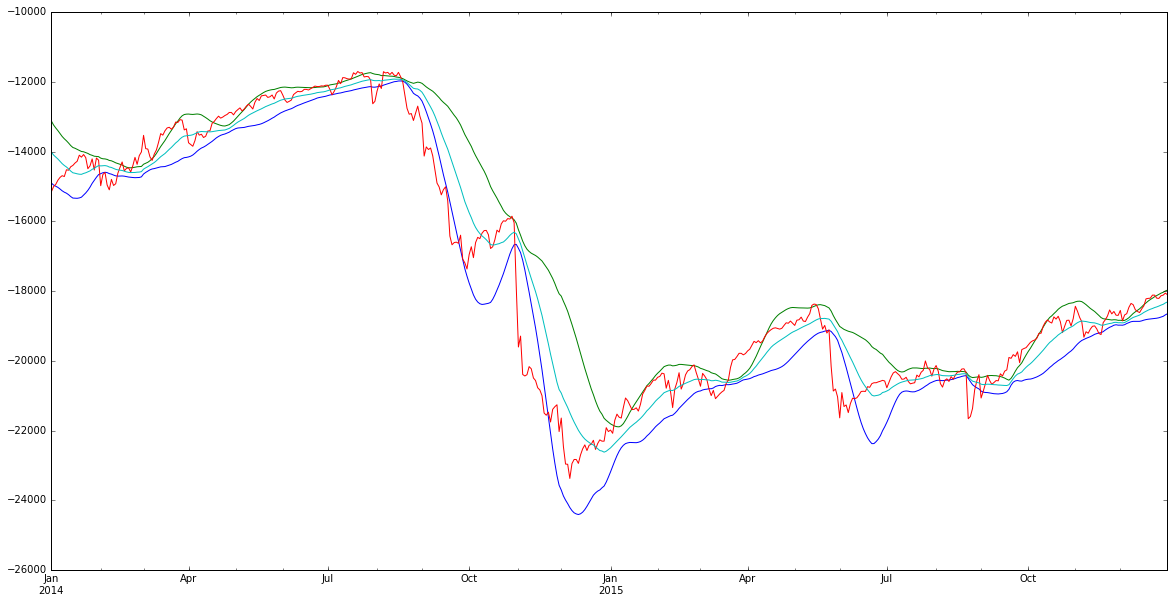

In [56]:

df.bb_lowerband.ix['2014':'2015'].plot()
df.bb_upperband.ix['2014':'2015'].plot()
df.exo.ix['2014':'2015'].plot()
df.bb_central_line.ix['2014':'2015'].plot()

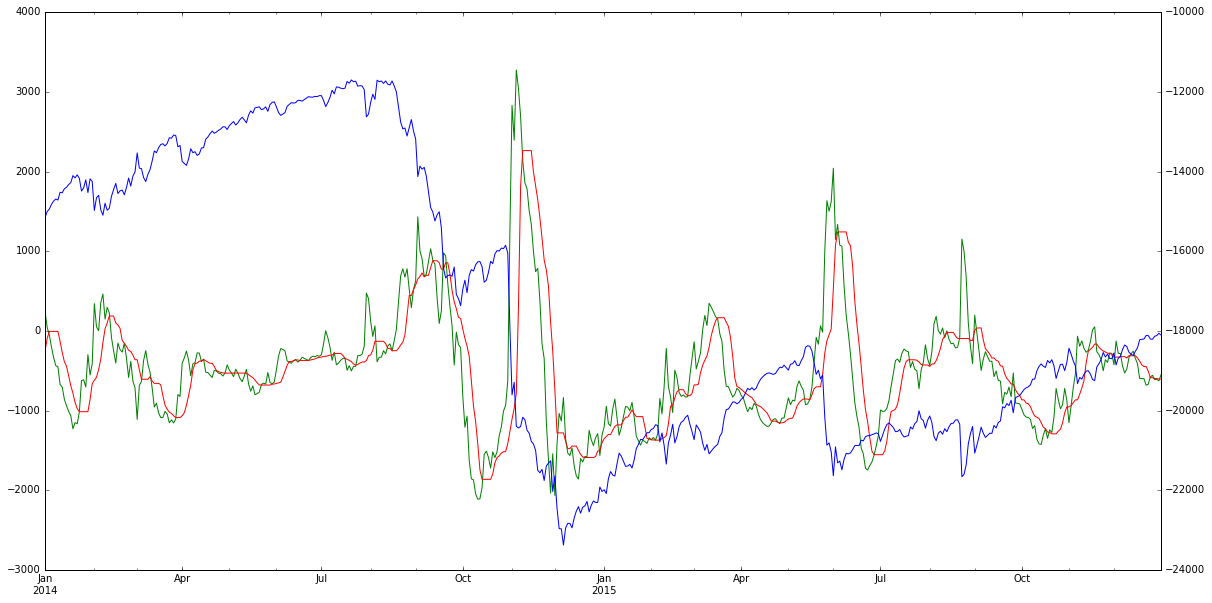

In [15]:
df.exo.ix['2014':'2015'].plot(secondary_y=True)
(df.bb_lowerband -  df.exo).ix['2014':'2015'].plot()

(df.bb_lowerband -  df.exo).rolling(10).median().ix['2014':'2015'].plot()

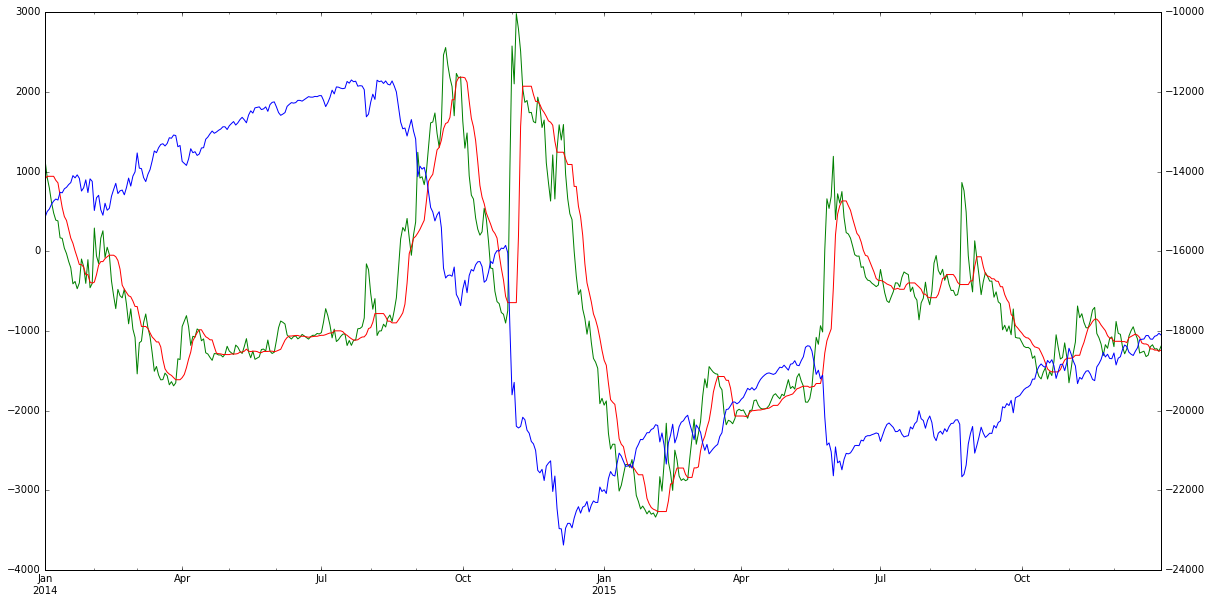

In [58]:
df.exo.ix['2014':'2015'].plot(secondary_y=True)
(df.bb_multiperiod_lowerband -  df.exo).ix['2014':'2015'].plot()

(df.bb_multiperiod_lowerband -  df.exo).rolling(10).median().ix['2014':'2015'].plot()

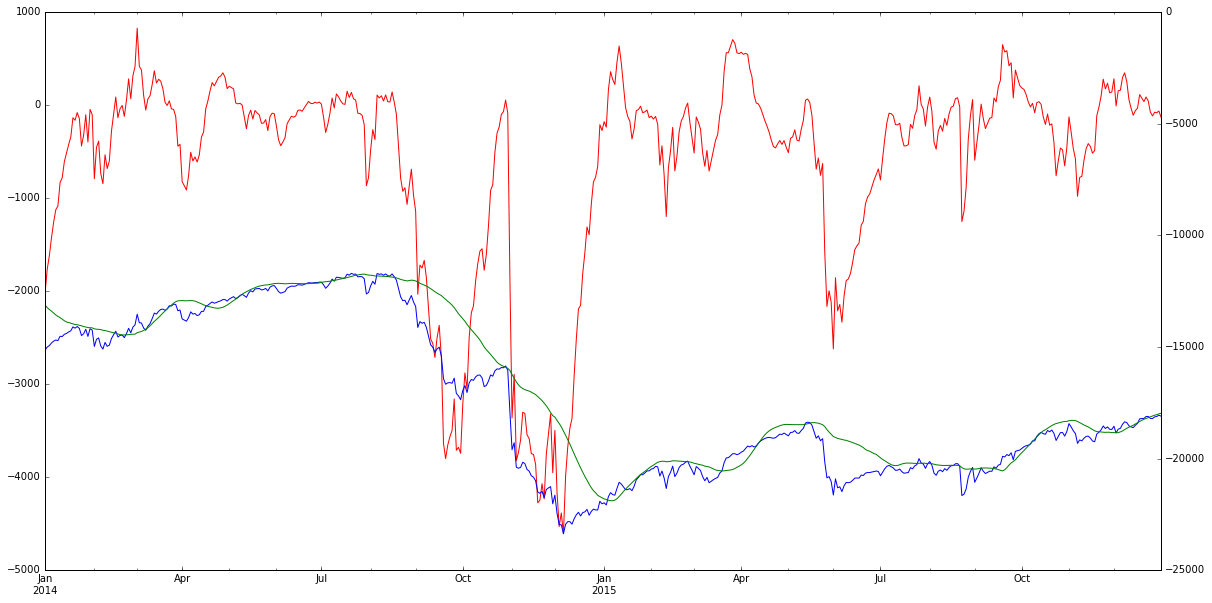

In [43]:
df.exo.ix['2014':'2015'].plot(secondary_y=True)
df.bb_upperband.ix['2014':'2015'].plot(secondary_y=True)

(df.exo - df.bb_upperband).ix['2014':'2015'].plot()

#(df.exo - df.bb_upperband).rolling(10).median().ix['2014':'2015'].plot()

#((((df.exo - df.bb_upperband).rolling(10).median()) <= (df.exo - df.bb_upperband))+1).ix['2014':'2015'].plot(secondary_y=True)
axhline(y=0)

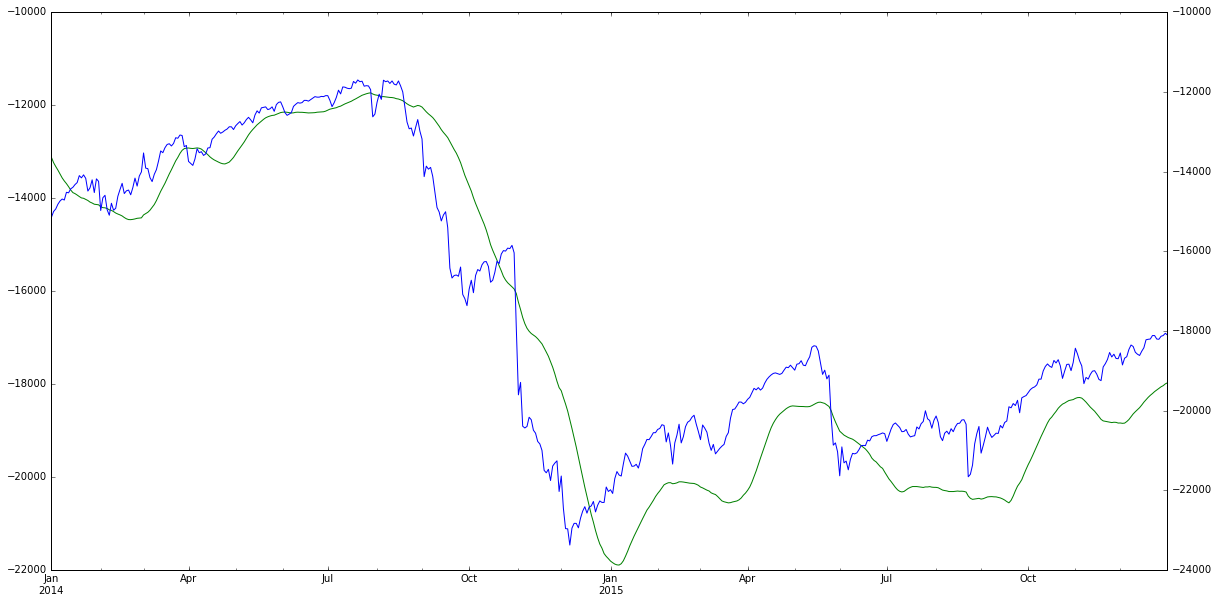

In [17]:
df.exo.ix['2014':'2015'].plot(secondary_y=True)

df.bb_upperband.ix['2014':'2015'].plot()

#(df.exo - df.bb_upperband).rolling(10).median().ix['2014':'2015'].plot()



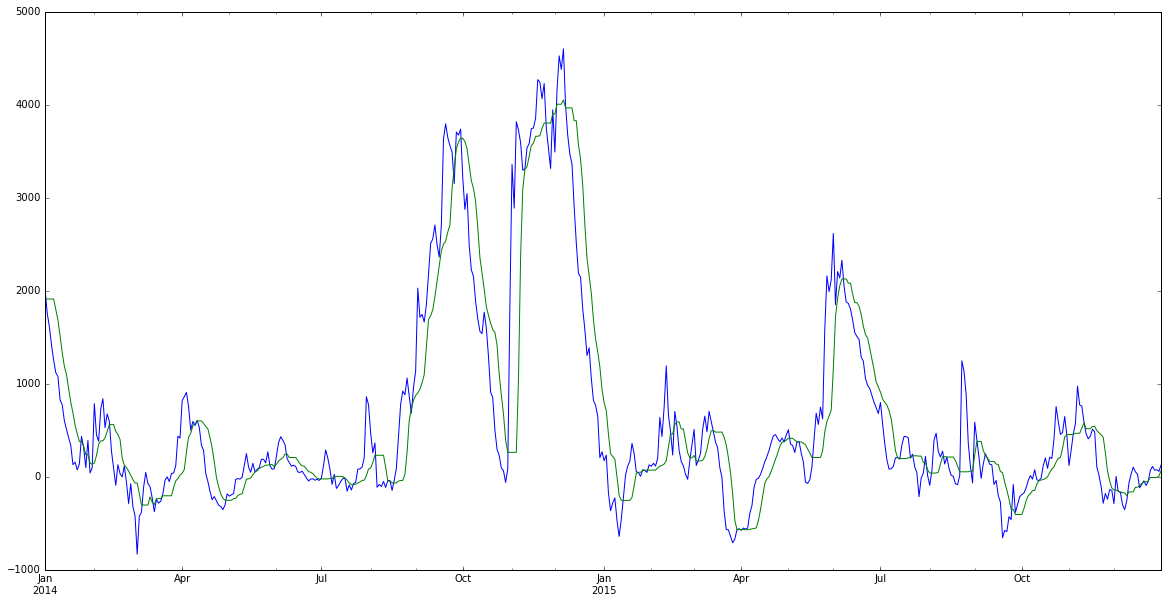

In [61]:
(df.bb_upperband -  df.exo).ix['2014':'2015'].plot()

(df.bb_upperband -  df.exo).rolling(10).median().ix['2014':'2015'].plot()

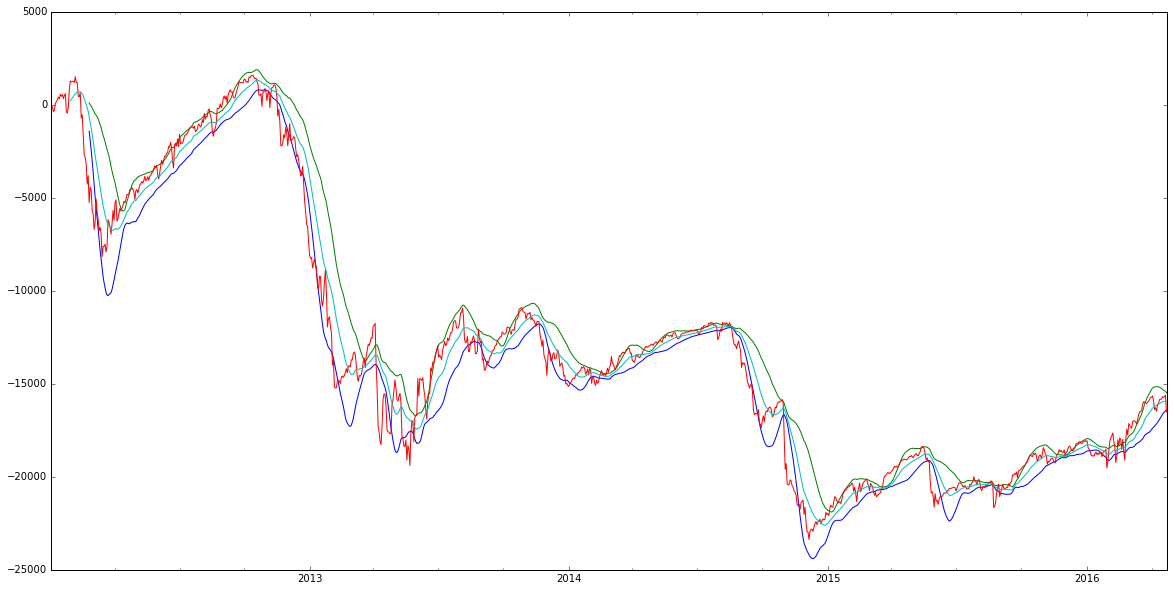

In [62]:
df.bb_lowerband.plot()
df.bb_upperband.plot()
df.exo.plot()
df.bb_central_line.plot()

#df['bb_%b'].rank(pct=True).plot(secondary_y=True)

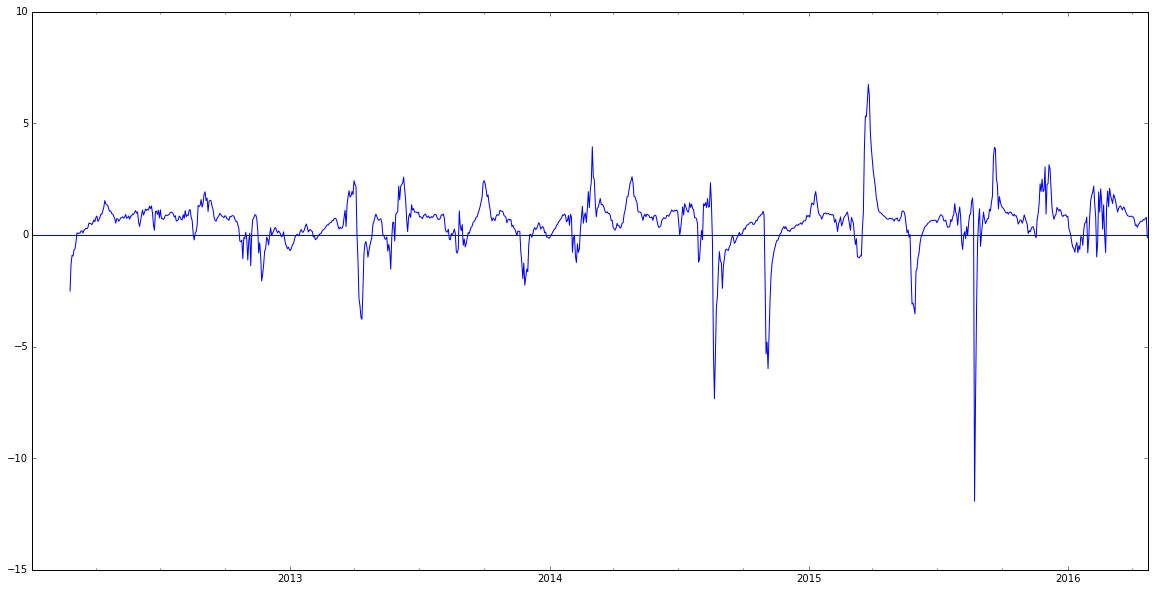

In [14]:
df['bb_%b'].plot()
axhline(y=0)

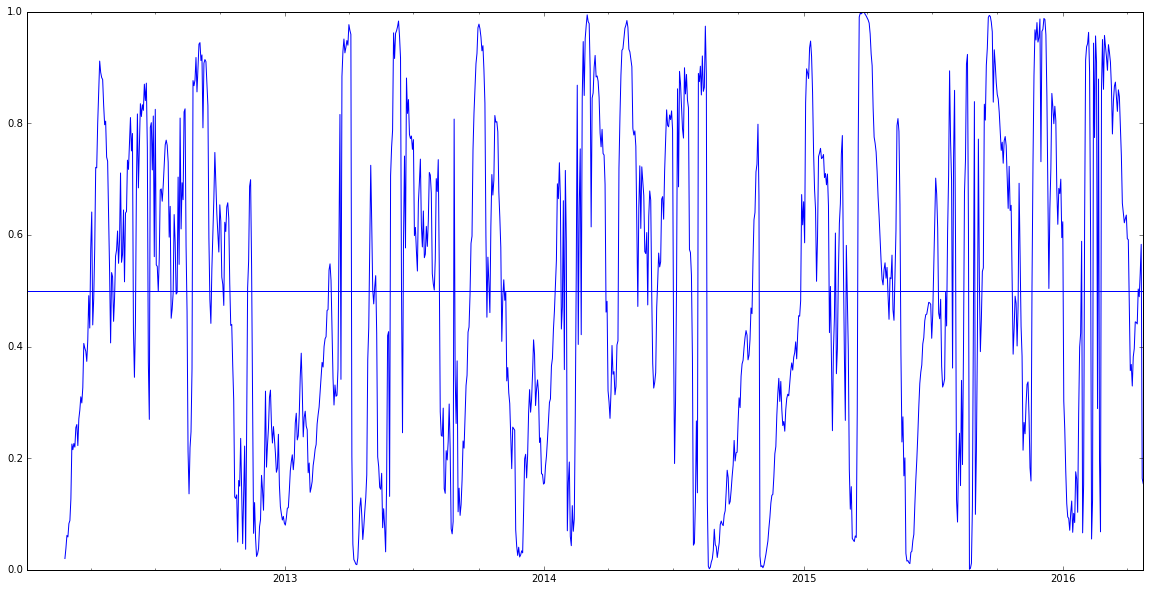

In [15]:
df['bb_%b'].rank(pct=True).plot()
axhline(y=0.5)

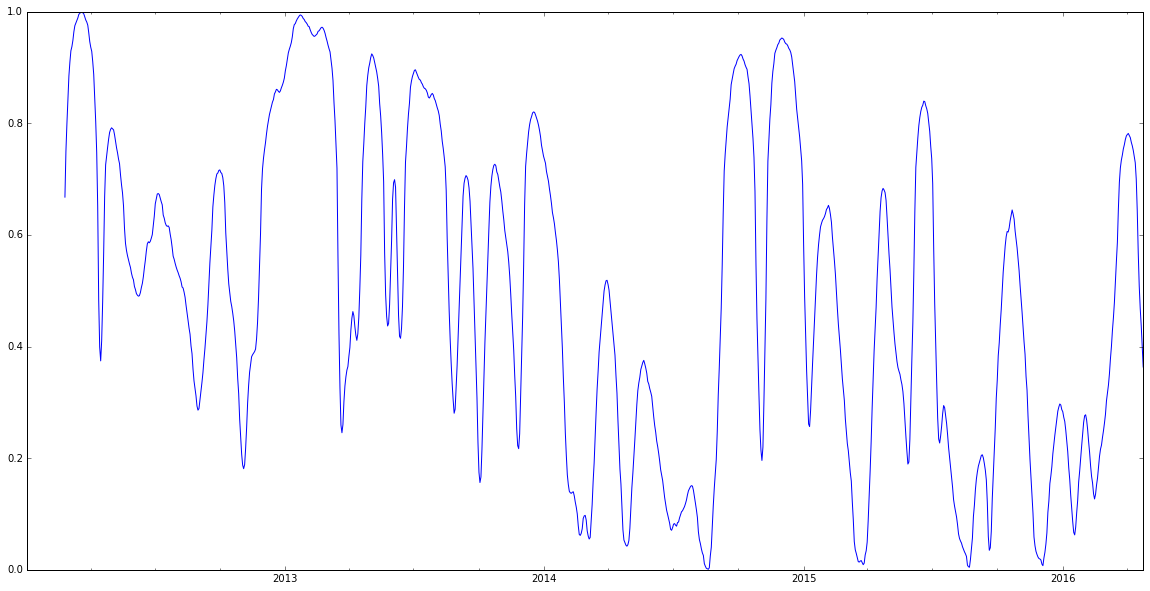

In [54]:
from sklearn import preprocessing
#pd.Series(preprocessing.scale(df.bb_width.dropna()), index=df.bb_width.dropna().index).plot()
df.bb_width.rank(pct=True).plot()
#axhline(y=0.5)

# Patterns

In [65]:
up_trend = (((df.exo - df.bb_upperband).rolling(10).median()) <= (df.exo - df.bb_upperband))

down_trend = (df.bb_lowerband -  df.exo).rolling(10).median()  <= (df.bb_lowerband -  df.exo)

bb_width_pctrank_less_20 = df.bb_width.rank(pct=True) <= 0.2
bb_width_pctrank_less_10 = df.bb_width.rank(pct=True) <= 0.1

bb_width_pctrank_more_80 = df.bb_width.rank(pct=True) >= 0.8
bb_width_pctrank_more_90 = df.bb_width.rank(pct=True) <= 0.9

bb_width_pctrank_more_50 = df.bb_width.rank(pct=True) >= 0.5
bb_width_pctrank_less_50 = df.bb_width.rank(pct=True) <= 0.5

bb_pctb_pctrank_less_20 = df['bb_%b'].rank(pct=True) <= 0.2
bb_pctb_pctrank_less_10 = df['bb_%b'].rank(pct=True) <= 0.1

bb_pctb_pctrank_more_80 = df['bb_%b'].rank(pct=True) >= 0.8
bb_pctb_pctrank_more_90 = df['bb_%b'].rank(pct=True) <= 0.9

bb_pctb_pctrank_more_50 = df['bb_%b'].rank(pct=True) >= 0.5
bb_pctb_pctrank_less_50 = df['bb_%b'].rank(pct=True) <= 0.5

In [66]:
multiperiod_up_trend = ((df.exo - df.bb_multiperiod_upperband).rolling(10).median()) <= (df.exo - df.bb_multiperiod_upperband)

multiperiod_down_trend = (df.bb_multiperiod_lowerband -  df.exo).rolling(10).median()  <= (df.bb_multiperiod_lowerband -  df.exo)

bb_multiperiod_width_pctrank_less_20 = df.bb_multiperiod_width.rank(pct=True) <= 0.2
bb_multiperiod_width_pctrank_less_10 = df.bb_multiperiod_width.rank(pct=True) <= 0.1

bb_multiperiod_width_pctrank_more_80 = df.bb_multiperiod_width.rank(pct=True) >= 0.8
bb_multiperiod_width_pctrank_more_90 = df.bb_multiperiod_width.rank(pct=True) <= 0.9

bb_multiperiod_width_pctrank_more_50 = df.bb_multiperiod_width.rank(pct=True) >= 0.5
bb_multiperiod_width_pctrank_less_50 = df.bb_multiperiod_width.rank(pct=True) <= 0.5

bb_multiperiod_pctb_pctrank_less_20 = df['bb_multiperiod_%b'].rank(pct=True) <= 0.2
bb_multiperiod_pctb_pctrank_less_10 = df['bb_multiperiod_%b'].rank(pct=True) <= 0.1

bb_multiperiod_pctb_pctrank_more_80 = df['bb_multiperiod_%b'].rank(pct=True) >= 0.8
bb_multiperiod_pctb_pctrank_more_90 = df['bb_multiperiod_%b'].rank(pct=True) <= 0.9

bb_multiperiod_pctb_pctrank_more_50 = df['bb_multiperiod_%b'].rank(pct=True) >= 0.5
bb_multiperiod_pctb_pctrank_less_50 = df['bb_multiperiod_%b'].rank(pct=True) <= 0.5

bb_multiperiod_pctb_up_direction = (df['bb_multiperiod_%b'].rank(pct=True).rolling(10).mean() >= 
                                    df['bb_multiperiod_%b'].rank(pct=True).rolling(10).mean().rolling(10).median()) 

bb_multiperiod_pctb_down_direction = (df['bb_multiperiod_%b'].rank(pct=True).rolling(10).mean() <= 
                                    df['bb_multiperiod_%b'].rank(pct=True).rolling(10).mean().rolling(10).median())


In [67]:
d

,exo,fut_price,volume,bb_central_line10,bb_upperband10,bb_lowerband10,bb_central_line20,bb_upperband20,bb_lowerband20,bb_central_line30,...,bb_multiperiod_central_line,bb_multiperiod_upperband,bb_multiperiod_lowerband,bb_central_line,bb_upperband,bb_lowerband,bb_%b,bb_width,bb_multiperiod_%b,bb_multiperiod_width
2012-01-03,-187.50,163325.00,37036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,-106.25,163125.00,55765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,-375.00,162175.00,68452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,-293.75,162412.50,58062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,75.00,162775.00,32675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,175.00,162850.00,40222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-11,281.25,162762.50,47650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-12,412.50,163000.00,50352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,318.75,162600.00,59615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-16,568.75,162950.00,29509,86.875,NaN,NaN,NaN,NaN,NaN,NaN,...,86.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
np.arange(10)[:5]

array([0, 1, 2, 3, 4])

In [38]:
np.arange(10)[5:]

array([5, 6, 7, 8, 9])